# Лабораторная работа № 2

## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 1

В данной части работы рассмотрены:
- подготовка признаков для рашения задачи **линейной регрессии**;
- создание и обучение модели линейной регрессии;
- оценка качества модели.ели.

### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, length, when
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    user_name = "dchel"
    
    conf = SparkConf()
    conf.setAppName("Lab 2")
    conf.setMaster("local[*]")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    # conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    # conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    # conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Загрузка датасета

In [5]:
df = spark.read.parquet("hdfs://namenode:9000/user/dchel/dchel_database/eCommerce_clear_data")

def print_df(df):
    return df.limit(10).toPandas()

In [6]:
print_df(df)

,event_type,product_id,brand,price,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone
0,purchase,3601248,indesit,167.289993,True,False,False,True,False
1,view,8700613,sonar,20.590000,True,False,False,False,False
2,purchase,1005099,samsung,154.410004,False,False,True,False,True
3,cart,1801537,haier,360.079987,False,False,True,False,False
4,view,18300878,thule,110.360001,False,False,False,False,False
5,view,13200717,redford,253.550003,False,False,False,False,False
6,purchase,4804581,xiaomi,37.770000,False,False,True,False,False
7,view,28718040,millionaire,79.019997,False,False,False,False,False
8,view,2701697,bosch,523.020020,True,False,False,True,False
9,purchase,1004785,huawei,276.700012,False,False,True,False,True


Расшифровка столбцов
| Название столбца  | Расшифровка |
| ------------- | ------------- |
| asin | ID товара  |
|reviewerID  |ID рецензента  |
|reviewerName  |Имя рецензента  |
|reviewText  |Текст отзыва  |
|overall  |Общая оценка  (1.0-5.0)|
|summary  |Краткое описание  |
|unixReviewTime  |Время отзыва в Unix-времени  
| reviewTime | Время отзыва ||

Вспомним схему данных

In [7]:
df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- contains_appliances: boolean (nullable = true)
 |-- contains_computers: boolean (nullable = true)
 |-- contains_electronics: boolean (nullable = true)
 |-- contains_kitchen: boolean (nullable = true)
 |-- contains_smartphone: boolean (nullable = true)



Вычислим количество строк в датафрейме.

In [8]:
df.count()

190323

### Постановка задачи GBT регрессии
Для датасета, заданного представленными колонками, требуется построить модель GBT регрессии 
для оценки рейтинга отзыва `(overall)` по всем остальным признакам.

Для оценки качества обучения следует использовать метрики RMSE и R².

### Подготовка и кодирование признаков

Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл. Он понадобится в следующей лабораторной работе.

In [9]:
# Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 1000) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения csv-файла.

In [10]:
path = "streaming-data.csv"

df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Файл "streaming-data.csv" с данными успешно создан.


Оцениваем, сколько строк в датасете осталось

In [11]:
df.count()

189287

Разделим датасет на обучающую и тестовую выборки.

In [12]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [13]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test dataset size: {test_df.count()}")

Train dataset size: 151236
Test dataset size: 38051


#### Создаем бинарные признаки на основе цены

In [14]:
df = df.withColumn("is_expensive", when(col("price") > 200, 1).otherwise(0))
df = df.withColumn("is_budget", when(col("price") < 50, 1).otherwise(0))
df = df.withColumn("is_mid_range", when((col("price") >= 50) & (col("price") <= 200), 1).otherwise(0))

#### Признаки на основе категорий продуктов

In [15]:
df = df.withColumn("category_count", 
                   col("contains_appliances").cast("int") + 
                   col("contains_computers").cast("int") + 
                   col("contains_electronics").cast("int") + 
                   col("contains_kitchen").cast("int") + 
                   col("contains_smartphone").cast("int"))

#### Признаки на основе типа события

In [16]:
df = df.withColumn("is_purchase", when(col("event_type") == "purchase", 1).otherwise(0))
df = df.withColumn("is_view", when(col("event_type") == "view", 1).otherwise(0))
df = df.withColumn("is_cart", when(col("event_type") == "cart", 1).otherwise(0))

#### Группируем цены в диапазоны

In [17]:
df = df.withColumn("price_range", 
                   when(col("price") < 50, "budget")
                   .when(col("price") < 150, "affordable")
                   .when(col("price") < 300, "premium")
                   .otherwise("luxury"))

# Создаем числовое представление для price_range
df = df.withColumn("price_range_numeric",
                   when(col("price_range") == "budget", 1)
                   .when(col("price_range") == "affordable", 2)
                   .when(col("price_range") == "premium", 3)
                   .otherwise(4))
df.printSchema()
df.limit(10).toPandas()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- contains_appliances: boolean (nullable = true)
 |-- contains_computers: boolean (nullable = true)
 |-- contains_electronics: boolean (nullable = true)
 |-- contains_kitchen: boolean (nullable = true)
 |-- contains_smartphone: boolean (nullable = true)
 |-- is_expensive: integer (nullable = false)
 |-- is_budget: integer (nullable = false)
 |-- is_mid_range: integer (nullable = false)
 |-- category_count: integer (nullable = true)
 |-- is_purchase: integer (nullable = false)
 |-- is_view: integer (nullable = false)
 |-- is_cart: integer (nullable = false)
 |-- price_range: string (nullable = false)
 |-- price_range_numeric: integer (nullable = false)



,event_type,product_id,brand,price,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone,is_expensive,is_budget,is_mid_range,category_count,is_purchase,is_view,is_cart,price_range,price_range_numeric
0,cart,1002042,samsung,77.139999,False,False,True,False,True,0,0,1,2,0,0,1,affordable,2
1,cart,1002524,apple,513.450012,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
2,cart,1002524,apple,513.469971,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
3,cart,1002524,apple,531.409973,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
4,cart,1002524,apple,533.260010,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
5,cart,1002524,apple,540.270020,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
6,cart,1002536,apple,576.570007,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
7,cart,1002542,apple,488.790009,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
8,cart,1002544,apple,460.070007,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
9,cart,1002544,apple,460.309998,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4


Идентификатор product_id не оказывают влияния на оценку отзыва. Использовать их в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные признаки**: пока отсутствуют в исходных данных
* **Бинарные признаки**: создадим из текстовых данных
* **Количественные признаки**: временные метки и производные от текста
* **Текстовые признаки**: преобразуем в числовые (длина текста)

In [18]:
# Обновим датафреймы train и test с новыми признаками
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(train_df.count())
print(test_df.count())

151660
37627


In [19]:
# Определим группы признаков для модели
binary_features = [
    "is_expensive", 
    "is_budget", 
    "is_mid_range", 
    "is_purchase", 
    "is_view", 
    "is_cart",
    "contains_appliances",
    "contains_computers",
    "contains_electronics",
    "contains_kitchen",
    "contains_smartphone"
]

numeric_features = ["category_count"]

categorical_features = ["brand", "event_type", "price_range", "price_range_numeric"]

# Целевая переменная
label_col = "price"

print("Категориальные признаки:", categorical_features)
print("Бинарные признаки:", binary_features)
print("Числовые признаки:", numeric_features)
print("Целевая переменная:", label_col)

Категориальные признаки: ['brand', 'event_type', 'price_range', 'price_range_numeric']
Бинарные признаки: ['is_expensive', 'is_budget', 'is_mid_range', 'is_purchase', 'is_view', 'is_cart', 'contains_appliances', 'contains_computers', 'contains_electronics', 'contains_kitchen', 'contains_smartphone']
Числовые признаки: ['category_count']
Целевая переменная: price


Отсутсвие категориальных признаков никак не помешает Gradient Boosted Trees Regressor, поскольку данная модель отличнно работает с только с числовыми признаками и изначально разработана для работы с ними.

Создадим конвейер обработки данных, включающий модель GBTRegressor

In [20]:
def create_gbt_pipeline(categorical_features: list[str], numeric_features: list[str], 
                       binary_features: list[str], label_col: str) -> Pipeline:
    
    stages = []
    
    # Обработка категориальных признаков (если есть)
    if categorical_features:
        indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
        # onehot_categorical_features = [f"{feature}_ohe" for feature in categorical_features]
        
        string_indexer = StringIndexer(inputCols=categorical_features,
                                      outputCols=indexed_categorical_features,
                                      handleInvalid="keep",
                                      stringOrderType="frequencyDesc")
        # onehot_encoder = OneHotEncoder(inputCols=indexed_categorical_features,
        #                               outputCols=onehot_categorical_features,
        #                               dropLast=True,
        #                               handleInvalid="keep")
        # stages.extend([string_indexer, onehot_encoder])
        stages.append(string_indexer)
    
    # Собираем числовые признаки в вектор
    vector_num_assembler = VectorAssembler(inputCols=numeric_features,
                                          outputCol="numeric_vector")
    stages.append(vector_num_assembler)
    
    # Масштабируем числовые признаки (опционально для GBT, но может помочь)
    # numeric_scaler = MinMaxScaler(inputCol="numeric_vector",
    #                             outputCol="numeric_vector_scaled")
    # stages.append(numeric_scaler)
    
    # Собираем все features в финальный вектор
    # feature_cols = ["numeric_vector_scaled"] + binary_features

    feature_cols = ["numeric_vector"] + binary_features
    
    vector_all_assembler = VectorAssembler(inputCols=feature_cols,
                                          outputCol="features")
    stages.append(vector_all_assembler)
    
    # Создаем модель GBTRegressor
    gbt_regression = GBTRegressor(featuresCol="features",
                                 labelCol=label_col,
                                 predictionCol="prediction",
                                 maxIter=100,
                                 maxDepth=5,
                                 seed=42)
    
    stages.append(gbt_regression)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [21]:
pipeline = create_gbt_pipeline(categorical_features=categorical_features,
                              numeric_features=numeric_features,
                              binary_features=binary_features,
                              label_col=label_col)
print("Конвейер успешно создан!")

Конвейер успешно создан!


### Обучение модели

Выполним **подбор гиперпараметров** модели GBTRegressor с помощью кросс-валидации на сетке

Создаем сетку параметров для кросс-валидации, получив объект `GBTRegressor` из конвейера

In [22]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxDepth, [3, 5]) \
    .addGrid(pipeline.getStages()[-1].maxIter, [100]) \
    .addGrid(pipeline.getStages()[-1].stepSize, [0.1]) \
    .build()

Создаем экземпляр `RegressionEvaluator` для оценки модели

In [23]:
cv_evaluator = RegressionEvaluator(labelCol=label_col,
                                   predictionCol="prediction",
                                   metricName="rmse")

Создаем объект `CrossValidator`

In [24]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=2,  
                                 parallelism=4)  

Обучаем модель конвейера с использованием кросс-валидации.

In [25]:
print("Начинаем обучение модели GBTRegressor с кросс-валидацией...")
cv_model = cross_validator.fit(train_df)
print("Обучение завершено!")

Начинаем обучение модели GBTRegressor с кросс-валидацией...
Обучение завершено!


Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [26]:
def get_best_gbt_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    gbt_model = best_model.stages[-1]
    
    best_params = {
        "maxDepth": gbt_model.getMaxDepth(),
        "maxIter": gbt_model.getMaxIter(),
        "stepSize": gbt_model.getStepSize()
    }
    return best_params

In [27]:
print("Параметры лучшей модели GBTRegressor:")
for key, value in get_best_gbt_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

Параметры лучшей модели GBTRegressor:
maxDepth: 5
maxIter: 100
stepSize: 0.1


### Анализ процесса обучения

In [28]:
def plot_gbt_training_metrics(cv_model: CrossValidatorModel, test_data: DataFrame) -> None:
    """
    Анализ метрик GBTRegressor на тестовой выборке и важность признаков.
    """
    # Делаем предсказания на тестовой выборке
    test_predictions = cv_model.transform(test_data)
    
    # Вычисляем метрики
    rmse_evaluator = RegressionEvaluator(labelCol=label_col, 
                                        predictionCol="prediction", 
                                        metricName="rmse")
    r2_evaluator = RegressionEvaluator(labelCol=label_col, 
                                      predictionCol="prediction", 
                                      metricName="r2")
    
    test_rmse = rmse_evaluator.evaluate(test_predictions)
    test_r2 = r2_evaluator.evaluate(test_predictions)
    
    print("МЕТРИКИ GBTRegressor НА ТЕСТОВОЙ ВЫБОРКЕ:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Визуализируем важность признаков
    best_model = cv_model.bestModel
    gbt_model = best_model.stages[-1]
    
    feature_importance = gbt_model.featureImportances.toArray()
    feature_names = numeric_features + binary_features
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Важность признака')
    plt.title(f'GBTRegressor - Важность признаков\nTest RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

МЕТРИКИ GBTRegressor НА ТЕСТОВОЙ ВЫБОРКЕ:
RMSE: 65.8857
R²: 0.7862


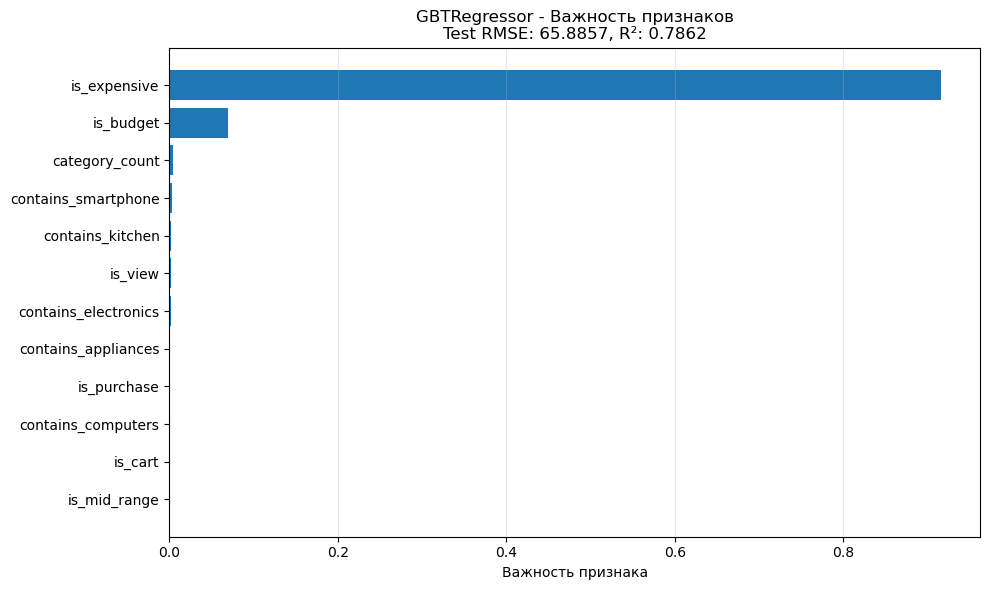

МЕТРИКИ GBTRegressor НА ТЕСТОВОЙ ВЫБОРКЕ:
RMSE: 65.9345
R²: 0.7862


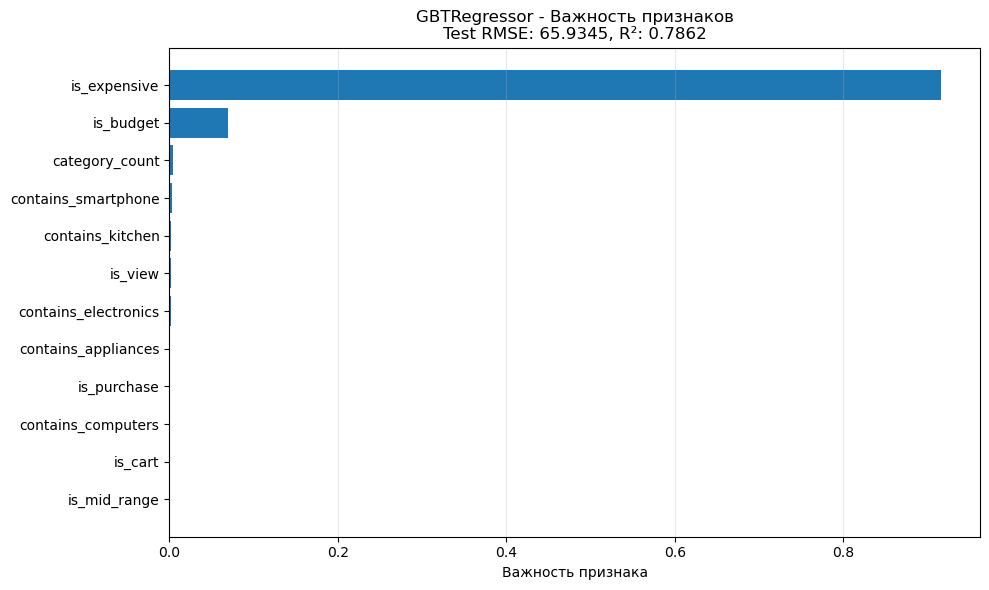

In [29]:
plot_gbt_training_metrics(cv_model, train_df)
plot_gbt_training_metrics(cv_model, test_df)

### Проверка обобщающей способности модели

Выполним предсказания на тестовой выборке.

Перегруппируем колонки датафрейма, переставив столбец с целевой переменной в конец,  чтобы его значения было удобно сравнивать с предсказанным


In [30]:
print("Выполняем предсказания на тестовой выборке...")
test_df_predictions = cv_model.transform(test_df)

right_columns_order = test_df_predictions.columns
right_columns_order.remove(label_col)
right_columns_order.append(label_col)

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)

print("Пример предсказаний (первые 10 строк):")
print_df(test_df_predictions)

Выполняем предсказания на тестовой выборке...
Пример предсказаний (первые 10 строк):


,event_type,product_id,brand,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone,is_expensive,is_budget,...,price_range,price_range_numeric,brand_index,event_type_index,price_range_index,price_range_numeric_index,numeric_vector,features,prediction,price
0,cart,1002524,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,513.469971
1,cart,1002536,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,576.570007
2,cart,1002544,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,460.070007
3,cart,1002629,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,358.309998
4,cart,1003114,sony,False,False,True,False,True,0,0,...,affordable,2,13.0,2.0,0.0,0.0,[2.0],"(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",140.276134,139.259995
5,cart,1003304,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,578.520020
6,cart,1003306,apple,False,False,True,False,True,1,0,...,luxury,4,3.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,583.169983
7,cart,1003439,gionee,False,False,True,False,True,0,0,...,affordable,2,578.0,2.0,0.0,0.0,[2.0],"(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",140.276134,74.650002
8,cart,1004059,xiaomi,False,False,True,False,True,1,0,...,luxury,4,1.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,378.130005
9,cart,1004060,xiaomi,False,False,True,False,True,1,0,...,luxury,4,1.0,2.0,3.0,3.0,[2.0],"(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",315.674862,358.279999


Создадим функцию оценки модели: расчета метрик для некоторого датасета

In [31]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol=label_col, 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

Оценим модель на тестовой выборке

In [32]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE на тестовых данных: {test_rmse:.4f}")
print(f"R² на тестовых данных: {test_r2:.4f}")

RMSE на тестовых данных: 65.9345
R² на тестовых данных: 0.7862


Выводы:
- Модель ошибается в среднем на 1 балл.
- Модель объясняет только 19% изменчивости оценок.
- Модель слабо предсказывает оценки отзывов.
- Большая часть изменчивости (81%) не объясняется текущими признаками.

### Сохранение модели

In [33]:
# Путь модели
model_path = f"lr-movies-model"

database_name = "dchel_database"
model_table_name = "gbt_eCommerce_model"

output_path = f"hdfs://namenode:9000/user/dchel/{database_name}/{model_path}"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(output_path)
    print(f"Модель GBTRegressor успешно сохранена в \"{output_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Ошибка при сохранении модели: An error occurred while calling o3627.save.
: java.io.IOException: Path hdfs://namenode:9000/user/dchel/dchel_database/lr-movies-model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.P

In [34]:
spark.stop()